# Project 4: Whale Calls

## Descripción general


**Conjunto de datos:** Llamados de ballenas para prevenir colisiones
El problema es clasificar un caso como ballena franca o no basándose en una señal de audio. Esos casos positivos contienen un conjunto de llamados ascendentes de ballena franca. Los llamados ascendentes son la vocalización de ballena franca más comúnmente documentada con una firma acústica de aproximadamente 60 Hz a 250 Hz, que generalmente dura 1 segundo. Cada serie está etiquetada como que contiene una ballena franca o no con el objetivo de identificar correctamente la serie que contiene llamados ascendentes. Los llamados de ballena franca a menudo pueden ser difíciles de escuchar ya que la banda de baja frecuencia puede congestionarse con sonidos antropogénicos como ruido de barcos, perforaciones, pilotes u operaciones navales.

Cada caso es un segmento de audio de dos segundos muestreado a 2 kHz, lo que da una longitud de serie de 4000.

**Instrucciones**


*   Analice y extraiga las características del conjunto de datos pertinentes al problema que seleccionó en el paso anterior. Justifique sus decisiones.
*   Elige al menos dos métodos (incluido al menos uno aprendido en clase) para resolver el desafío propuesto que seleccionaste. Justifica tus decisiones.
*   Informar las métricas adecuadas. Analizar y discutir los resultados de cada método.

## 1. Importación de librerías

In [ ]:
%pip install --user numpy
%pip install --user pandas
%pip install --user matplotlib
%pip install --user cvxopt
%pip install --user seaborn
%pip install --user pywavelets
%pip install --user librosa
%pip install --user scikit-learn
%pip install --user torch torchvision

In [24]:
import os
import math
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
import pywt
import librosa

from IPython.display import Audio

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = 'D:\\ml-final-project\\Dataset\\'
print(device)

cpu


## 2. Extracción de características

**Probando la apertura de un archivo .wav**

Feacture Vector of the Whale sound:
[[-4.4031815e+02 -4.8852032e+02 -6.7340765e+02 ... -6.7620264e+02
  -6.7970630e+02 -6.8723218e+02]
 [ 1.3070174e+02  1.5624869e+02  2.0042212e+02 ...  1.9805307e+02
   1.9332701e+02  1.8095755e+02]
 [ 5.8356752e+00  2.3758247e+01  1.1995216e+02 ...  1.2141680e+02
   1.1751323e+02  1.0307147e+02]
 ...
 [ 1.0459026e+01  1.1853057e+01  1.5014218e+01 ...  2.7122636e+00
  -6.5301669e-01 -2.5440555e+00]
 [ 8.7445583e+00  9.8233070e+00  4.6593580e+00 ... -4.2680798e+00
  -6.0563993e+00 -5.8613300e+00]
 [ 4.1834736e+00  4.6094790e+00 -3.9704609e+00 ... -7.2885995e+00
  -7.1501579e+00 -6.0969458e+00]]


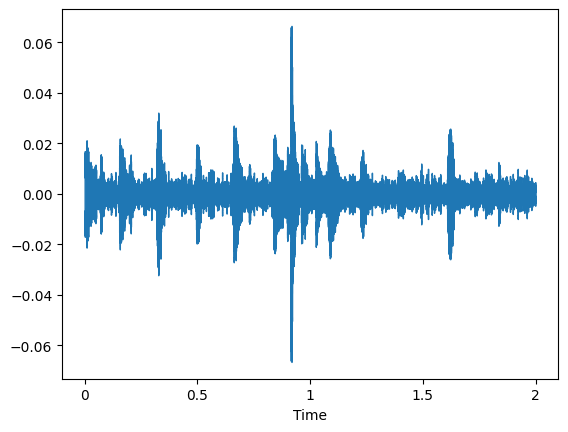

In [9]:
y, sr = librosa.load(path + "train/0.wav" )
mfccs = librosa.feature.mfcc(y=y, sr=sr)
feacture_vector = np.array(mfccs)
print("Feacture Vector of the Whale sound:")
print(feacture_vector)
librosa.display.waveshow(y, sr=sr)
Audio(data=y, rate=sr)

**Mapeando los labels a 0 y 1**

In [70]:
df = pd.read_csv(path + 'train.csv', header=None)
data_dict = dict(zip(df.iloc[1:, 0], df.iloc[1:, 1]))
mapping = {'NoWhale': 0, 'RightWhale': 1}
converted_dict = {k: mapping[v] for k, v in data_dict.items()}
#print(converted_dict)

In [48]:
# Número de coeficientes MFCC
n_mfcc = 20

def process_data(path, data_type='train', test_size=0.2, random_state=42):
    data = []
    labels = []
    directory = os.listdir(os.path.join(path, data_type))
    print(directory)
    i = 0
    for f in directory:
        y, sr = librosa.load(os.path.join(path, data_type, f))
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs = np.expand_dims(mfccs, axis=0)
        data.append(mfccs)
        labels.append(converted_dict[f.split('.')[0]])
        print(i)
        print(f)
        i += 1
    
    data = np.array(data)
    labels = np.array(labels)
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    
    # Convertir los datos y las etiquetas en Tensores de PyTorch
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Crear conjuntos de datos de PyTorch
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Crear DataLoaders de PyTorch
    batch_size = 64 
    train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)
    
    for images, labels in train_loader:
      print(f"Shape of images in a batch: {images.size()}")
      break
    
    print(f"Train DataLoader size: {len(train_loader.dataset)}, Test DataLoader size: {len(test_loader.dataset)}")
    print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
    print(f"X_test_tensor shape: {X_test_tensor.shape}, y_test_tensor shape: {y_test_tensor.shape}")
   
    return train_loader, test_loader

In [50]:
def process_data_to_predict(path, data_type='test'):
    data = []
    filenames = []
    directory = os.listdir(os.path.join(path, data_type))
    print(directory)
    i = 0
    for f in directory:
        y, sr = librosa.load(os.path.join(path, data_type, f))
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs = np.expand_dims(mfccs, axis=0)
        data.append(mfccs)
        filenames.append(f.split('.')[0])
        print(i)
        print(f)
        i += 1
    
    data = np.array(data)
    
    # Convertir los datos a tensor de PyTorch
    X_predict_tensor = torch.tensor(data, dtype=torch.float32)
    
    # Crear conjunto de datos de PyTorch
    predict_dataset = TensorDataset(X_predict_tensor)
    
    # Crear DataLoader de PyTorch
    X_predict_loader = DataLoader(dataset=predict_dataset, shuffle=False, batch_size=64)
    
    return X_predict_loader, filenames

## 3. Modelos

### 3.1. CNN

In [31]:
# Hiperparámetros
num_classes = 2
learning_rate = 0.0001
num_epochs = 100
batch_size = 64

In [32]:
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self, num_classes=4):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))

    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))

    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      
    self.fc_input_dim = self._get_conv_output((1, 20, 87))
    print(self.fc_input_dim) # 2560 
    self.fc = nn.Linear(self.fc_input_dim, num_classes)
    # self.fc = nn.Linear(128*2*10, num_classes)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out

  def _get_conv_output(self, shape):
    # Create a test tensor with the specified dimensions
    batch_size = 1
    input = torch.rand(batch_size, *shape)
    # Pass the test tensor through the convolutional layers
    output_feat = self.layer1(input)
    output_feat = self.layer2(output_feat)
    output_feat = self.layer3(output_feat)
    # Calculate the size of the flattened output
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

In [45]:
def train(model, train_loader, num_epochs):
  # Here we are setting up the loss function and the optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # running_loss = 0.0
  total_step = len(train_loader)
  list_loss = []
  list_time = []

  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      output = model(images)
      loss = loss_fn(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      list_loss.append(loss.item())
      list_time.append(i)
      i += 1

      if (i + 1) % 5 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
              .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

  print('Finished Training Trainset')
  return list_loss

In [34]:
def test(model, test_loader):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_accuracy = 100 * correct / total
  return test_accuracy, correct, total

## 4. Main Program

In [ ]:
train_loader, test_loader = process_data(path, data_type = 'train')

In [ ]:
x_predict_loader, filenames = process_data_to_predict(path, data_type = 'test')

In [ ]:
model = CNN().to(device)

# Training
list_loss = train(model, train_loader, num_epochs)

In [72]:
print(list_loss[-1])

0.060642484575510025


In [57]:
# Testing
test_accuracy, correct, total = test(model, test_loader)

**Gráficas**


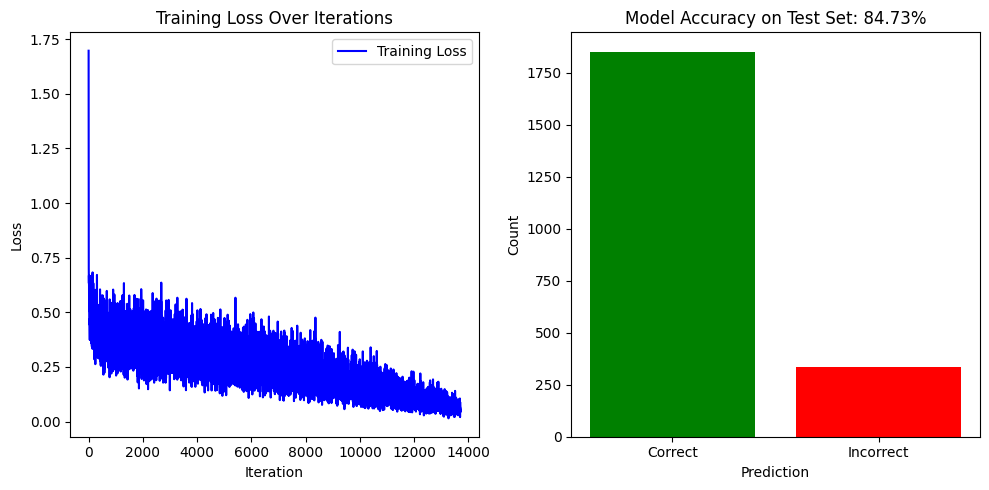

In [54]:
# Plot the loss function
plt.figure(figsize=(10, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['Correct', 'Incorrect'], [correct, total - correct], color=['green', 'red'])
plt.title(f'Model Accuracy on Test Set: {test_accuracy:.2f}%')
plt.xlabel('Prediction')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Predict**

In [66]:
def predict(model, x_predict_loader):
  model.eval()
  all_predictions = []
  with torch.no_grad():
    for images in x_predict_loader:
      images = images[0].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      all_predictions.extend(predicted.cpu().numpy())
  return all_predictions

In [67]:
y_predict = predict(model, x_predict_loader)

**Generación de submission.csv**

In [69]:
class_mapping = {
    0: 'NoWhale',
    1: 'RightWhale'
}

df = pd.DataFrame({
    'idx': range(len(y_predict)),
    'class': [class_mapping[pred] for pred in y_predict],
})

# Ordenar por el valor de idx
df = df.sort_values(by='idx')
df.to_csv('submission.csv', index=False)

### 4.1. Métricas